# LSTM을 활용하여 카카오 주가 예측하기

* 필요한 Library
    * yfinance :
        * yahoo finance [[ref]](https://github.com/ranaroussi/yfinance)
        * conda install yfinance
    * fbprophet : 
        * 시계열 데이터로 예측을 하기 위한 모듈 [[ref]](https://facebook.github.io/prophet/)
        * pip3 install fbprophet
    * pandas_datareader 
        * 웹 상의 데이터를 DataFrame 객체로 만드는 함수를 포함하는 모듈 [[ref]](https://pandas-datareader.readthedocs.io/en/latest/)
        * pip3 install pandas_datareader
    * pandas, numpy, seaborn, sklearn, tensorflow

* Reference
    * https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/
    * https://bziwnsizd.tistory.com/33
    * https://coding-yoon.tistory.com/131
    * https://colab.research.google.com/github/teddylee777/machine-learning/blob/master/04-TensorFlow2.0/01-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1/02-LSTM-stock-forecasting-with-LSTM-financedatareader.ipynb
    * https://dataplay.tistory.com/19
    * https://github.com/KerasKorea/KEKOxTutorial/blob/master/22_Keras%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EC%A3%BC%EC%8B%9D%20%EA%B0%80%EA%B2%A9%20%EC%98%88%EC%B8%A1.md
    * https://www.youtube.com/watch?v=LLLVYkXJw30&t=843s
    * https://www.youtube.com/watch?v=9haME49Rx_0&t=120s

## Preparation

In [1]:
import os, sys  
from google.colab import drive  
# drive.mount('/content/drive')   
pg_path = '/content/packages'  
# os.symlink('/content/drive/My Drive/Colab Notebooks', pg_path)  
sys.path.insert(0, pg_path)  
# !pip install --target=$pg_path yfinance
# !pip install --target=$pg_path pingouin


In [27]:
!pip install --target=$pg_path pingouin

     |████████████████████████████████| 182 kB 5.3 MB/s 
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
     |████████████████████████████████| 11.2 MB 39.4 MB/s 
     |████████████████████████████████| 292 kB 49.1 MB/s 
     |████████████████████████████████| 9.8 MB 30.1 MB/s 
     |████████████████████████████████| 24.8 MB 1.6 MB/s 
     |████████████████████████████████| 98 kB 8.0 MB/s 
     |████████████████████████████████| 40 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.2 MB/s 
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
     |████████████████████████████████| 4.3 MB 46.0 MB/s 
     |████████████████████████████████| 890 kB 44.2 MB/s 
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)
     |████████████████████████████████| 845 kB 54.

In [3]:
# unitility
import os, warnings
from copy import deepcopy
from datetime import datetime

# stock price data load
import yfinance as yf

# data handling
import pandas as pd
from pandas_datareader import data as dfr
import numpy as np

# modeling
import sklearn  # from sklearn import preprocessing, feature_selection, linear_model, svm, metrics, model_selection
import tensorflow as tf
from fbprophet import Prophet

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from IPython.core.display import display, HTML
from IPython.display import Image

In [4]:
#plot setting
plt.style.use('seaborn')  # plt.style.use('ggplot')
sns.set(font_scale=1.5)

plt.rc('font', family='AppleGothic') 
plt.rcParams['figure.figsize'] = [10, 5]
mpl.rcParams['axes.unicode_minus'] = False  

%matplotlib inline

#ignore warnings
warnings.filterwarnings('ignore') # 워닝 메세지를 생략해 줍니다. 차후 버전관리를 위해 필요한 정보라고 생각하시면 주석처리 하시면 됩니다.

In [5]:
# path setting
proj_dir = os.getcwd()
# data_dir = (os.getcwd() +  '/titanic')
os.chdir(proj_dir)

## Load Data

In [6]:
yf.pdr_override()

In [7]:
start_date= "2018-01-01"
end_date="2022-01-23"

In [8]:
kko = dfr.get_data_yahoo(tickers = '035720.KS', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


## Glimpse

In [9]:
kko.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,28000.0,29400.0,27900.0,29300.0,29225.351562,6729755
2018-01-03,30100.0,30200.0,29100.0,29800.0,29724.078125,5771805
2018-01-04,30500.0,31800.0,29900.0,31200.0,31120.513672,11325095


In [10]:
kko.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,57246.800000,58160.140000,56372.060000,57246.480000,57218.610314,3.404517e+06
std,42238.035113,42895.499179,41584.792031,42195.110482,42211.957935,2.647530e+06
min,17200.000000,18220.000000,17200.000000,17520.000000,17475.363281,0.000000e+00
25%,24400.000000,24800.000000,24000.000000,24375.000000,24320.723145,1.697571e+06
50%,31300.000000,31800.000000,30900.000000,31400.000000,31340.220703,2.581650e+06
75%,89625.000000,91500.000000,87225.000000,88875.000000,88875.000000,4.201070e+06
max,172000.000000,173000.000000,161000.000000,169500.000000,169500.000000,2.611002e+07


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


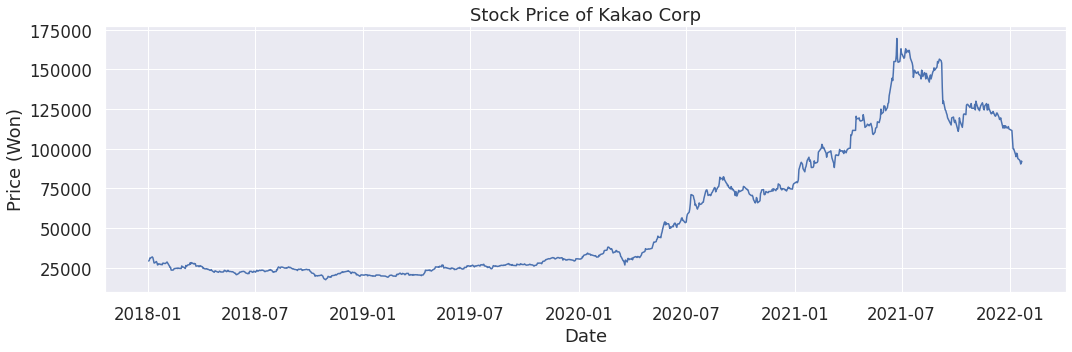

In [11]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = kko, x='Date', y='Close')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

## "fbprophet" library로 Forecasting 하기

### Data Split

In [12]:
df = deepcopy(kko)


train_df = df[:'2021-8-01'].filter(['Close']).reset_index()
test_df = df['2021-8-01':].filter(['Close']).reset_index()

In [13]:
print(train_df.shape, test_df.shape)

(883, 2) (117, 2)


* Prophet에 사용하기 위해 날짜를 ds, 종가를 y로 바꾸어준다.

In [14]:
train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']

### Modeling

* fbprophet 라이브러리의 Prophet API 사용 [[ref]](https://hyperconnect.github.io/2020/03/09/prophet-package.html)
* help(Prophet)

In [15]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)

In [16]:
model.fit(train_df)

### Prediction

In [17]:
mid = datetime.strptime('2021-8-01', "%Y-%m-%d")
end = datetime.strptime(end_date, "%Y-%m-%d")
date_diff = end - mid
date_diff.days

175

In [18]:
future_day = model.make_future_dataframe(periods=date_diff.days)
pred_df = model.predict(future_day)

In [19]:
print(pred_df.shape)
pred_df.head(3)

(1058, 22)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,29801.861640,25046.406796,33316.045261,29801.861640,29801.861640,-536.668374,-536.668374,-536.668374,2537.012388,2537.012388,2537.012388,73.704645,73.704645,73.704645,-3147.385407,-3147.385407,-3147.385407,0.0,0.0,0.0,29265.193266
1,2018-01-03,29801.670384,25051.031829,33747.115307,29801.670384,29801.670384,-242.613237,-242.613237,-242.613237,2537.012388,2537.012388,2537.012388,267.097792,267.097792,267.097792,-3046.723418,-3046.723418,-3046.723418,0.0,0.0,0.0,29559.057146
2,2018-01-04,29801.479128,25162.539907,33671.142478,29801.479128,29801.479128,-162.835642,-162.835642,-162.835642,2537.012388,2537.012388,2537.012388,248.246543,248.246543,248.246543,-2948.094574,-2948.094574,-2948.094574,0.0,0.0,0.0,29638.643485


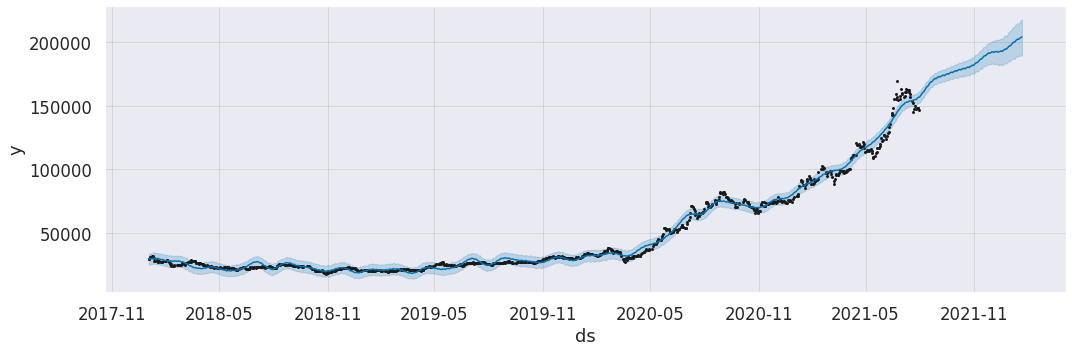

In [20]:
model.plot(pred_df[["ds", "yhat", "yhat_lower", "yhat_upper"]], figsize=(15, 5));

### Performance Check

* 

In [21]:
df_tmp = deepcopy(df.reset_index())
df_tmp = df_tmp.filter(['Date', 'Close', 'High', 'Low'])
df_tmp.columns = ['ds', 'y', 'High', 'Low']

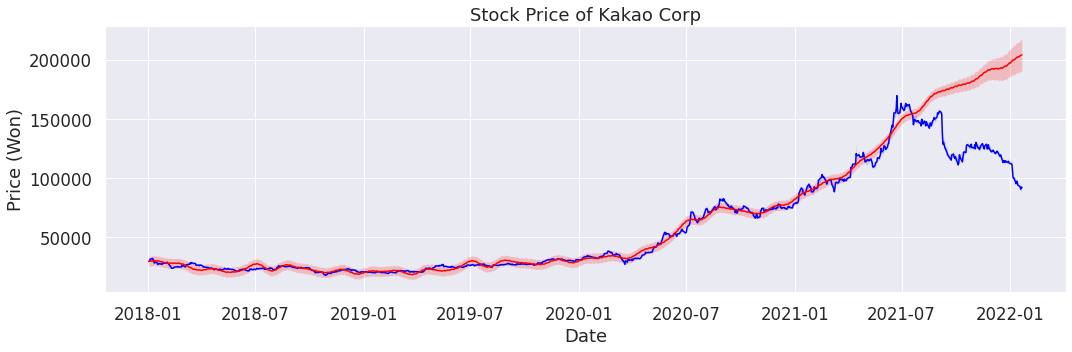

In [22]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = df_tmp, x='ds', y='y', color='blue')
g1.fill_between(data= df_tmp, x='ds', y1='Low', y2='High', 
                facecolor='blue', alpha=0.2)

g1 = sns.lineplot(data = pred_df, x='ds', y='yhat', color='red')
g1.fill_between(data= pred_df, x='ds', y1='yhat_lower', y2='yhat_upper', 
                facecolor='red', alpha=0.2)
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [23]:
predicted = pd.merge(pred_df, test_df, how = 'right')[['ds','yhat','y']]

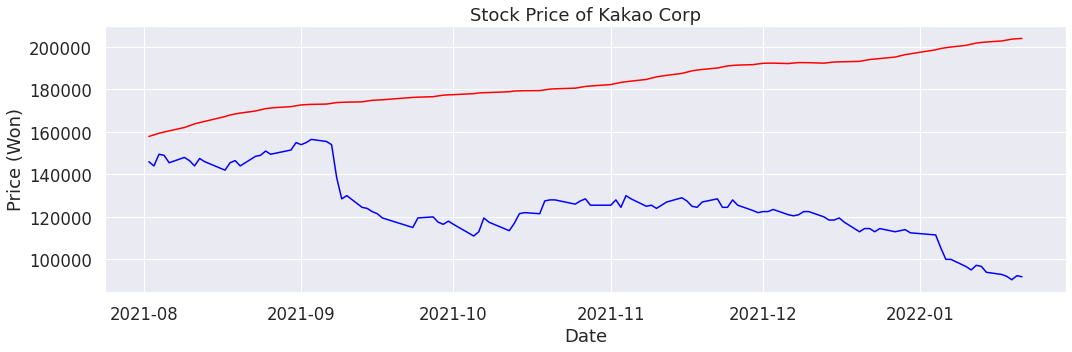

In [24]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = predicted, x='ds', y='y', color='blue')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [28]:
from sklearn import metrics
print('mse :', metrics.mean_squared_error(predicted.y, predicted.yhat))
print('mae :', metrics.mean_absolute_error(predicted.y, predicted.yhat))

mse : 4085482602.5852118
mae : 58150.32809787083


In [29]:
import pingouin as pg
pg.corr(predicted.y, predicted.yhat,
        alternative="two-sided",
        method="pearson") # pearson, spearman, kendall, bicor, percbend, shepherd, skipped

,n,r,CI95%,p-val,BF10,power
pearson,117,-0.825048,"[-0.88, -0.76]",2.776511e-30,1.224e+27,1.0


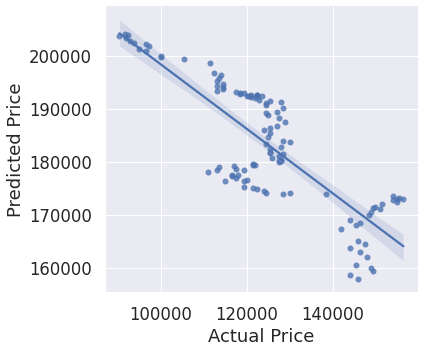

In [30]:
g = sns.lmplot(x="y", y="yhat", data=predicted, height=5, aspect=1.2);
g.set_axis_labels("Actual Price", "Predicted Price")
plt.tight_layout()
plt.show()

## LSTM으로 Forecasting 하기

### Data Preparation

In [83]:
df2 = deepcopy(kko)
# train_df = df2[:df2[df2.Date == '2021-8-01'].index[0]]
# test_df = df2[df2[df2.Date == '2021-8-01'].index[0]:]
train_df = df2[:'2021-8-01'].reset_index()
test_df = df2['2021-8-01':].reset_index()

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
train_df_f = scaler.fit_transform(train_df[scale_cols])
train_df_f = pd.DataFrame(train_df_f)
train_df_f.columns = scale_cols
train_df = pd.concat([train_df.Date, train_df_f], axis = 1)


test_df_f = scaler.transform(test_df[scale_cols])
test_df_f = pd.DataFrame(test_df_f)
test_df_f.columns = scale_cols
test_df = pd.concat([test_df.Date, test_df_f], axis = 1)


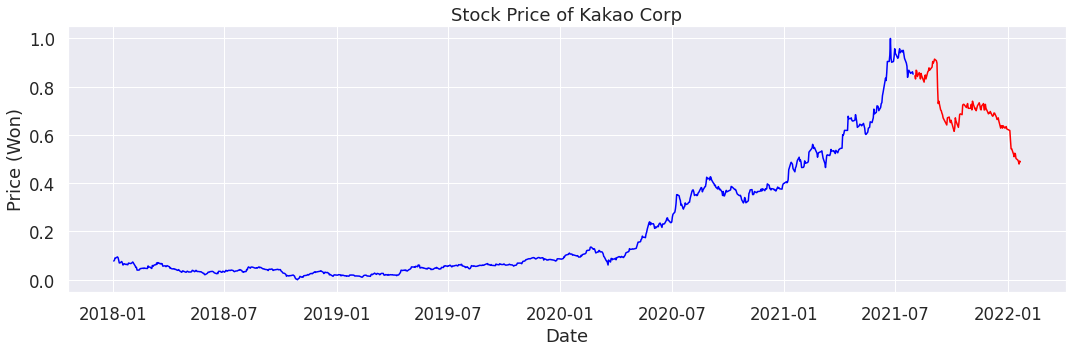

In [85]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = train_df, x='Date', y='Close', color='blue')
g1 = sns.lineplot(data = test_df, x='Date', y='Close', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [86]:
def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [87]:
window_size=20
train_x = train_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
train_y = train_df['Close']
train_x, train_y = make_dataset(train_x, train_y, window_size)

test_x = test_df[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
test_y = test_df['Close']
test_x, test_y = make_dataset(test_x, test_y, window_size)

In [88]:
train_x[0][9]

array([0.07170543, 0.07287763, 0.07719054, 0.24224876, 0.0753217 ])

In [89]:
train_y[0]

0.0669824976970654

In [90]:
train_df.loc[9,:]

Date         2018-01-15 00:00:00
Open                   0.0717054
High                   0.0728776
Low                    0.0771905
Close                  0.0755363
Adj Close              0.0753217
Volume                  0.242249
Name: 9, dtype: object

In [91]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(863, 20, 5) (863,)
(97, 20, 5) (97,)


In [92]:
train_x[0][0], train_y[0], train_df.loc[10,:]

(array([0.06976744, 0.07223155, 0.0744089 , 0.25774607, 0.07729003]),
 0.0669824976970654,
 Date         2018-01-16 00:00:00
 Open                   0.0755814
 High                   0.0696472
 Low                    0.0751043
 Close                  0.0696144
 Adj Close              0.0694167
 Volume                   0.21407
 Name: 10, dtype: object)

In [93]:
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(train_x, train_y, test_size=0.2)
x_train.shape, x_valid.shape

((690, 20, 5), (173, 20, 5))

### Modeling

In [94]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

# model setting
model = keras.models.Sequential()
model.add(keras.layers.LSTM(16, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# callback setting
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


In [95]:
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
41/44 [==========================>...] - ETA: 0s - loss: 0.0186
Epoch 00001: val_loss improved from inf to 0.00213, saving model to model/tmp_checkpoint.h5
44/44 [==============================] - 2s 17ms/step - loss: 0.0179 - val_loss: 0.0021
Epoch 2/200
39/44 [=========================>....] - ETA: 0s - loss: 0.0014
Epoch 00002: val_loss improved from 0.00213 to 0.00081, saving model to model/tmp_checkpoint.h5
44/44 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 8.1329e-04
Epoch 3/200
39/44 [=========================>....] - ETA: 0s - loss: 7.8621e-04
Epoch 00003: val_loss improved from 0.00081 to 0.00056, saving model to model/tmp_checkpoint.h5
44/44 [==============================] - 0s 10ms/step - loss: 7.7715e-04 - val_loss: 5.5791e-04
Epoch 4/200
38/44 [========================>.....] - ETA: 0s - loss: 6.5804e-04
Epoch 00004: val_loss improved from 0.00056 to 0.00053, saving model to model/tmp_checkpoint.h5
44/44 [=========================

In [96]:
model.load_weights(filename)
pred_y = model.predict(test_x)
pred_y.shape

(97, 1)

In [97]:
predicted = pd.concat([test_df.Date[window_size:].reset_index(), 
                       pd.DataFrame(test_y, columns=['y']), 
                       pd.DataFrame(pred_y, columns=['yhat'])], 
                      axis=1, ignore_index=True)

predicted.columns = ['idx','ds','y','yhat']

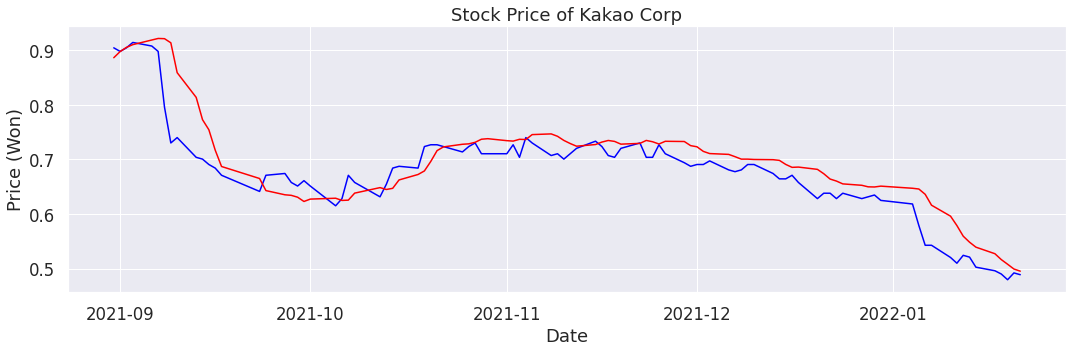

In [98]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = predicted, x='ds', y='y', color='blue')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='red')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()

In [99]:
from sklearn import metrics
print('mse :', metrics.mean_squared_error(predicted.y, predicted.yhat))
print('mae :', metrics.mean_absolute_error(predicted.y, predicted.yhat))

mse : 0.0017266956192354803
mae : 0.03010697503292957


In [100]:
import pingouin as pg
pg.corr(predicted.y, predicted.yhat,
        alternative="two-sided",
        method="pearson") # pearson, spearman, kendall, bicor, percbend, shepherd, skipped

,n,r,CI95%,p-val,BF10,power
pearson,97,0.920805,"[0.88, 0.95]",1.260529e-40,1.411e+37,1.0


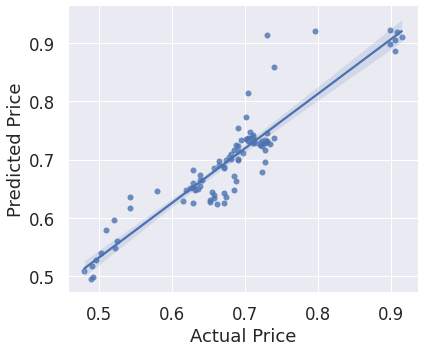

In [101]:
g = sns.lmplot(x="y", y="yhat", data=predicted, height=5, aspect=1.2);
g.set_axis_labels("Actual Price", "Predicted Price")
plt.tight_layout()
plt.show()

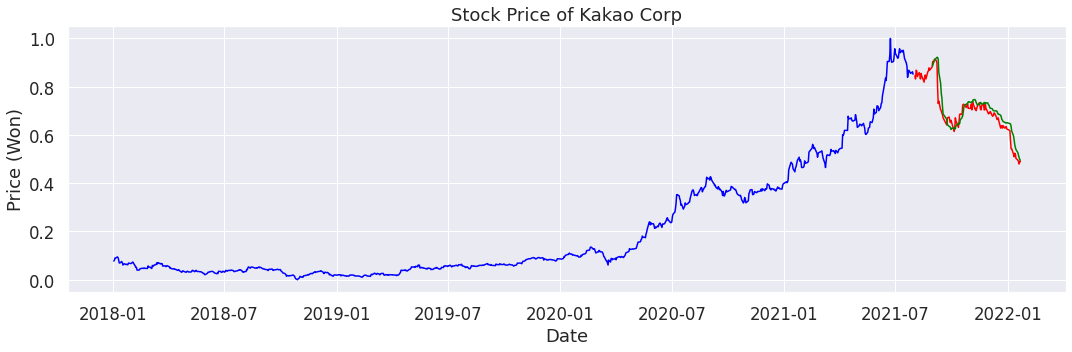

In [102]:
plt.figure(figsize=[15,5])
g1 = sns.lineplot(data = train_df, x='Date', y='Close', color='blue')
g1 = sns.lineplot(data = test_df, x='Date', y='Close', color='red')
g1 = sns.lineplot(data = predicted, x='ds', y='yhat', color='green')
g1.set_ylabel('Price (Won)')
g1.set_xlabel('Date')
g1.set_title('Stock Price of Kakao Corp')
plt.tight_layout()
plt.show()